In [ ]:
# default_exp plotting

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Ellipse
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.ndimage as ndimage
from cmath import *

from theonerig.core import *
from theonerig.processing import *
from theonerig.utils import *
from theonerig.modelling import *

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
#export
def plot_2d_sta(sta, grid=None, pval=None):
    sta = np.array(sta)
    if len(sta.shape) == 2:
        sta = [sta]
    if grid is None:
#         fig = plt.figure(figsize=(20,4+len(sta)//8*2))
        grid = gridspec.GridSpec(len(sta)//8 + 1, 8)    
        for i, frame in enumerate(sta):
            ax = plt.subplot(grid[i//8, i%8])
            ax.imshow(frame, cmap='gray',vmin=-1, vmax=1)
    else:
        grid_x, grid_y = grid.get_geometry()
        for i in range(grid_x):
            for j in range(grid_y):
                ax = plt.subplot(grid[i*grid_x+j])#fig.add_subplot(grid[i])
                ax.imshow(sta[i*grid_x+j], cmap='gray',vmin=-1, vmax=1)
                if i!=grid_x-1:
                    ax.set_xticks([])
                if j != 0:
                    ax.set_yticks([])
                    
                if i==0 and j==1:
                    if pval is None:
                        ax.set_title("Checkerboard")
                    else:
                        ax.set_title("Checkerboard p="+format_pval(pval))

In [ ]:
from os.path import join
import matplotlib.pyplot as plt
vivo_2p_dir = "./files/vivo_2p"
reM = import_record(join(vivo_2p_dir, "record_master.h5"))
pipe = Data_Pipe(reM, ["checkerboard", "eye_tracking", "S_matrix"], ["stim_inten", "eye_track", "spike_counts"])
pipe += "checkerboard"
result_sta = process_sta_batch(eyetrack_stim_inten(pipe[0]["stim_inten"], pipe[0]["eye_track"]), 
                               pipe[0]["spike_counts"], Hw=40)

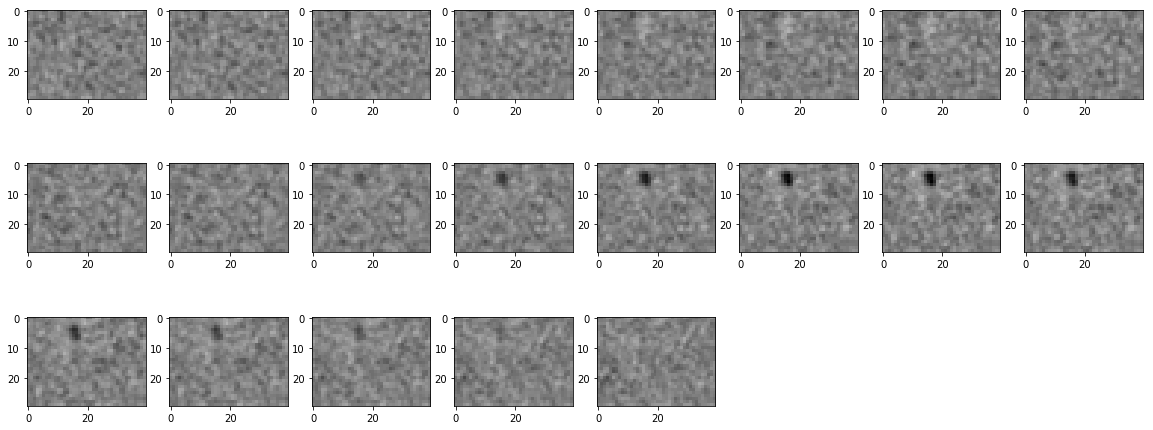

In [ ]:
plot_2d_sta(result_sta[0][::2])

In [ ]:
#export
def plot_cross_correlation(correlation_array, threshold=.1  ,two_sided=True):
    n_cell = correlation_array.shape[0]
    _min,_max = np.min(correlation_array), np.max(correlation_array)
    thresh = (_max-_min) * threshold
    for i in range(n_cell):
        for j in range(i, n_cell):
            c = "#1f77b4"
            if np.max(correlation_array[i,j])-np.min(correlation_array[i,j]) > thresh:
                c = "red"
            for k in range(2 if two_sided else 1):
                if k==0:
                    ax = fig.add_subplot(n_cell,n_cell,i*n_cell+j+1, ylim=(_min,_max), label=str(i*n_cell+j+1))
                else:
                    ax = fig.add_subplot(n_cell,n_cell,j*n_cell+i+1, ylim=(_min,_max), label="b"+str(i*n_cell+j+1))
                plt.plot(correlation_array[i,j], c=c)
                plt.axis('off')
                if i == 0 and k==0:
                    ax.set_title(str(j))  
                elif i == 0 and k==1:
                    ax.set_title(str(j), pad =-50, loc="left")  
                elif i == j:
                    ax.set_title(str(j), pad =-50, loc="center")

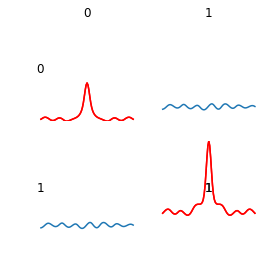

In [ ]:
pipe = Data_Pipe(reM, ["S_matrix"])
pipe += "checkerboard"
checker_corr = cross_correlation(pipe[0]["S_matrix"])
plot_cross_correlation(checker_corr, threshold=.3, figsize=(4,4))

In [ ]:
#export
def plot_2d_fit(sta, param_d):
    plt.subplot(1,2,1)
    plt.imshow(sta, vmin=-1,vmax=1, cmap="gray")
    plt.subplot(1,2,2)
    
    plt.imshow(img_2d_fit(sta.shape, param_d, f=sum_of_2D_gaussian), vmin=-1,vmax=1, cmap="gray")

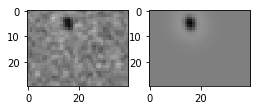

In [ ]:
sta = result_sta[0,25]
plot_2d_fit(sta, fit_spatial_sta(sta))

In [ ]:
#export
def plot_ds_wheel(ax, ds_dict, cell_idx):
    key_0 = list(ds_dict.keys())[0]

    n_angle = ds_dict[key_0][0].shape[1]
    x = np.linspace(0, (n_angle-1)/4*np.pi, num=n_angle)
    linestyle = [":", "--"]
    best_oi, best_di = None, None
    idx_best_oi, idx_best_di =  0, 0
    to_plot = []
    for j, (key, data) in enumerate(ds_dict.items()):
        spike_counts = data[0][cell_idx,:]
        dir_pref = data[1][cell_idx]
        dir_mod, dir_phase = polar(dir_pref)
        dir_pval = data[5][cell_idx]
        #We could aswell use the already calculated index but polar provide us an angle that can be plotted.
        ori_pref = data[3][cell_idx]
        ori_mod, ori_phase = polar(ori_pref)
        ori_pval = data[6][cell_idx]

        if best_oi is None:
            best_oi, best_di = (ori_mod, ori_phase, ori_pval), (dir_mod, dir_phase, dir_pval)
        else:
            if best_oi[2]<ori_pval:
                best_oi=(ori_mod, ori_phase, ori_pval)
                idx_best_oi = j
            if best_di[2]<dir_pval:
                best_di=(dir_mod, dir_phase, dir_pval)
                idx_best_di = j
                
        to_plot.append((key, spike_counts, dir_mod, dir_pval, ori_mod, ori_pval))
        
    for j, (key, spike_counts, dir_mod, dir_pval, ori_mod, ori_pval) in enumerate(to_plot):
        label = key+"   DI:"+str(round(dir_mod,2))+" / p"+str(round(1-dir_pval,2))
        if j==idx_best_di:
            label += " *"
        label += "    OI:"+str(round(ori_mod,2))+" / p"+str(round(1-ori_pval,2))
        if j==idx_best_oi:
            label += " *"

        ax.plot(np.concatenate((x, x[0:1])), np.concatenate((spike_counts, spike_counts[0:1])),
                linestyle=linestyle[j//2], c=DEFAULT_COLORS[j%2], 
                label=label)

    x_uplim = ax.get_ylim()[1]
    ds_arrow = ax.arrow(0,x_uplim/500,best_di[1],  best_di[0]*x_uplim, width=.3, head_width=x_uplim/1000000, color='tab:purple', label="Best DI")
    os_arrow = ax.arrow(0,x_uplim/500,best_oi[1],  best_oi[0]*x_uplim, width=.3, head_width=x_uplim/1000000, color='tab:green', label="Best OI")
    legend_obj, legend_label = ax.get_legend_handles_labels()
    #For double legend box, need to add manually the artist for the first legend
    first_legend = ax.legend(legend_obj, legend_label, loc=(-.1,-.16))
    plt.gca().add_artist(first_legend)
    ax.legend([ds_arrow, os_arrow], ["best direction index (DI)", "best orientation index (OI)"], loc=(-.1,.95), ncol=2)

In [ ]:
#export
def plot_dark_white_response(ax, spike_bins):
    """spike_bins must be of shape (2, n_cell, trial_len), the dark beeing at idx 0 and white at idx 1
    of the first dimension."""
    for i in range(spike_bins.shape[1]):
        ax.plot(spike_bins[0,i], label="dark", c="#000000")
        ax.plot(spike_bins[1,i], label="white", c="#8F8F8F")
        ax.set_title('Cell '+str(i))
        ax.legend()

In [ ]:
#export
def plot_fl_bars(ax, sta, pval=None):
    time_axis = np.round(np.linspace(0,len(sta)/60,len(sta))[::-1]*(-1),3)
    ax.imshow(sta, cmap='gray',vmin=-1, vmax=1, aspect="auto")
    ax.set_yticks(np.arange(0, len(sta), 1))
    ax.set_yticklabels(time_axis)
    
    if pval is None:
        ax.set_title("Flickering_bars")
    else:
        ax.set_title("Flickering_bars p="+format_pval(pval))

In [ ]:
#export
def plot_t_sta(ax, sta, pval=None):
    time_axis = np.linspace(0,len(sta)/60,len(sta))[::-1]*(-1)
    lns = ax.plot(time_axis,sta, label="STA norm")
    ax.set_ylim(-1,1)
    ax.legend()
        
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    if pval is None:
        ax.set_title("Fullfield_flickering")
    else:
        ax.set_title("Fullfield_flickering p="+format_pval(pval))

In [ ]:
#export
def plot_chirp(ax, stim_inten, spike_bins, smooth=True):
    #Getting the number of repeats by convolving a part of the stimulus
    conv_res  = np.convolve(stim_inten[360:600].astype(float), stim_inten.astype(float), mode="full")
    n_repeats = np.sum(conv_res.max()==conv_res)
     
    trace = spike_bins.reshape(n_repeats,-1)
    len_    = trace.shape[1]

    df = pd.DataFrame(columns=["timepoint","repeat","signal"])
    for i, repeat_am in enumerate(trace):
        if smooth:
            repeat_am = np.convolve([.333]*3, repeat_am, mode="same")
        repeat_df = pd.DataFrame(list(zip(np.linspace(0,len_/60,len_), 
                                          [str(i)]*len_, 
                                          repeat_am)), columns=["timepoint","repeat","signal"])
        df = df.append(repeat_df, ignore_index=True)
    g = sns.lineplot(x="timepoint", y="signal", data=df, ax=ax, n_boot=100) #Small n_boot to speed_up plotting
                                                                            # (default n_boot=10000)
#         trace = np.mean(trace, axis=0)
#         if smooth:
#             trace = np.convolve([.2]*3, trace, mode="same")
#         plt.plot(np.linspace(0,len_/60,len_), trace)
        
    min_val, max_val = ax.get_ylim()
    ax.set_ylim(min_val , (max_val-min_val)*6/5)
    ax.set(xlabel='', ylabel='')
    ax.imshow([stim_inten.reshape(n_repeats,-1)[0]], aspect='auto', cmap="gray", extent=(0,len_/60,(max_val-min_val)*6/5,max_val))

In [ ]:
#export
def plot_chirpam_fit(cell_mean, fit, start=390, stop=960):
    plt.figure()
    plt.plot(np.linspace(0, len(cell_mean)/60, len(cell_mean), endpoint=False), cell_mean)
    plt.plot(np.linspace(start/60, stop/60, stop-start, endpoint=False), sinexp_sigm(np.linspace(0, (stop-start)/60, stop-start, endpoint=False), *fit))
        
def plot_chirp_freq_epoch_fit(cell_mean, fit_l, freqs=[1.875,3.75,7.5,15,30], durations=[2,2,2,1,1], start=360):
    plt.figure()
    plt.plot(np.linspace(0, len(cell_mean)/60, len(cell_mean), endpoint=False), cell_mean)
    len_fits = [int(dur*freq)*int(60/freq) for dur,freq in zip(durations, freqs)] 
    cursor = start
    edgecut = 10
    for len_fit, dur, fit in zip(len_fits, durations, fit_l):
        cursor  += edgecut
        len_fit -= edgecut
        if fit is None:
            cursor += len_fit
            continue
        t = np.linspace(0, len_fit/60, len_fit*4, endpoint=False)
        plt.plot(t+(cursor/60), sin_exponent(t, *fit))
        
        cursor += len_fit

In [ ]:
#export
def plot_spike_template(ax, cluster_composition, templates, shanks_idx, channel_positions):
    tmp = cluster_composition[0]
    n_points = 30
    mask_trace = np.arange(templates.shape[1]//2-10, 
                           templates.shape[1]//2+(n_points-10))

    template_pos = np.where(np.abs(templates[tmp]) 
                            == np.max(np.abs(templates[tmp])))[1][0]
    template_shank = np.where(shanks_idx==template_pos)[0][0]
    selected_channels = shanks_idx[template_shank]
    selected_channels = selected_channels[selected_channels!=-1] #Removing the disabled channels
    shank_templates = templates[:,:,selected_channels]

    min_x = np.min(channel_positions[selected_channels][:,0])
    for i, pos in enumerate(channel_positions[selected_channels]):
        for j, cell in enumerate(cluster_composition):
            color = DEFAULT_COLORS[j%len(DEFAULT_COLORS)]
            ax.plot(np.arange(n_points)+pos[0]-min_x, shank_templates[cell,mask_trace,i]*4+pos[1], c=color)
    ax.set_title("Shank "+str(template_shank+1))
    
def plot_spike_template_MEA(ax, cluster_composition, templates, channel_positions):
    tmp = cluster_composition[0]
    n_points = 25
    mask_trace = np.arange(templates.shape[1]//2-10,
                           templates.shape[1]//2+(n_points-10))

    template_pos = channel_positions[np.where(np.abs(templates[tmp]) == np.max(np.abs(templates[tmp])))[1][0]]
    selected_channels = np.where(np.linalg.norm(channel_positions - template_pos, axis=1) < 100)[0]

    for i, pos in enumerate(channel_positions[selected_channels]):
        for j, cell in enumerate(cluster_composition):
            color = DEFAULT_COLORS[j%len(DEFAULT_COLORS)]
            ax.plot(np.arange(n_points)+pos[0], templates[cell, mask_trace,i]*4+pos[1], c=color)

    ax.set_ylim(template_pos[1]-150, template_pos[1]+150)
    ax.set_xlim(template_pos[0]-150, template_pos[0]+150)
    ax.set_title("X/Y pos: "+str(pos[0])+"/"+str(pos[1]))
    
def plot_autocorrelogram(ax, cluster, spike_times, spike_clusters, bin_ms=.001, sampling_rate=30000, tails=30):
    cluster_mask = spike_clusters==cluster
    cluster_times = spike_times[cluster_mask]
    hist = np.histogram(cluster_times, bins=np.linspace(0,cluster_times[-1], cluster_times[-1]/(bin_ms*sampling_rate)))[0]
    hist_tails = np.concatenate(([0]*tails, hist, [0]*tails))
    corr = np.correlate(hist_tails, hist, mode="valid")
    corr[tails]=0
    
    ax.bar(np.linspace(-tails*bin_ms*1000,tails*bin_ms*1000,tails*2+1), corr, width=bin_ms*1000)
    ax.set_title("Autocorrelogram, bin="+str(bin_ms*1000)+"ms")
    
def plot_spike_amplitudes(ax, cluster, spike_templates, spike_clusters, spike_times, amplitudes, n_max_dots=5000):
    mask_cluster = spike_clusters==cluster
    clusters = np.unique(spike_templates[mask_cluster])
    points_per_cluster = n_max_dots//len(clusters)
    total_spikes = 0
    for templ in clusters:
        mask_template = spike_templates==templ
        n_spike_template = np.sum(mask_template)
        total_spikes+=n_spike_template
        mask_selected_spikes = np.linspace(0, n_spike_template, min(n_spike_template, points_per_cluster), dtype=int, endpoint=False)
        plt.scatter(spike_times[mask_template][mask_selected_spikes], amplitudes[mask_template][mask_selected_spikes], s=1)

    ax.set_xticks([])
    ax.set_title("Spike amplitudes - n°spike: "+str(total_spikes))
    
def plot_cell_spatial(ax, cell_spatial):
    ax.imshow(cell_spatial)

def plot_calcium_trace(ax, cell_trace):
    ax.plot(range(0,len(cell_trace),8), cell_trace[::8], linewidth=.1)
    ax.set_xticks([])
    ax.set_title("Calcium activity")

def plot_stim_epochs_to_spikes(ax, reM, y_pos):
    pos_text_cursor = 1
    seq = reM._sequences[0]
    stim_names = seq.get_names_group("stim")
    idx_l = []
    for stim_name in stim_names:
        dc = seq._data_dict[stim_name][0]
        idx_l.append(dc.idx)
    idx_l = np.array(idx_l)
    order_stim = np.argsort(idx_l)
    for stim_idx in order_stim:
        stim_name = stim_names[stim_idx]
        dc = seq._data_dict[stim_name][0]
        len_dc = seq["main_tp"][dc.idx+len(dc)]-seq["main_tp"][dc.idx]
        start_dc = seq["main_tp"][dc.idx]
        ax.barh(y_pos, len_dc, left=start_dc, height=.1)
        ax.text(start_dc, y_pos+(.1*pos_text_cursor), stim_name, fontdict={"size":10})
        pos_text_cursor*=-1
        
def plot_stim_epochs_to_calcium(ax, reM, y_pos):
    pos_text_cursor = 1
    seq = reM._sequences[0]
    stim_names = seq.get_names_group("stim")
    idx_l = []
    for stim_name in stim_names:
        dc = seq._data_dict[stim_name][0]
        idx_l.append(dc.idx)
    idx_l = np.array(idx_l)
    order_stim = np.argsort(idx_l)
    for stim_idx in order_stim:
        stim_name = stim_names[stim_idx]
        dc = seq._data_dict[stim_name][0]
        len_dc = len(dc)
        start_dc = dc.idx
        ax.barh(y_pos, width=len_dc, left=start_dc, height=.1)
        ax.text(start_dc, y_pos+(.1*pos_text_cursor), stim_name, fontdict={"size":10})
        pos_text_cursor*=-1
        
def plot_stim_recap_table(ax, df):
    width_ratios = []
    for col in df.columns:
        width_ratios.append(max(5, len(col), max(map(len,map(str,df[col])))))
    widths = [w/np.sum(width_ratios) for w in width_ratios]
    
    ax.table(cellText=np.vstack([df.columns, df.values]), 
             cellColours=[['lightgray']*df.shape[1]] + [['none']*df.shape[1]]*df.shape[0], 
             bbox=[0,0,1,1],
             colWidths=widths)
    ax.axis('off')


In [ ]:
#export
def plot_composed_A_masks(ax, A_matrix):
    center_mass_l = []
    final_img = np.ones((3,*A_matrix.shape[1:]), dtype="float")
    for i, cell_A in enumerate(A_matrix):
        cell_A = cell_A/np.max(cell_A)
        hexa_color = DEFAULT_COLORS[i%len(DEFAULT_COLORS)]
        red, green, blue = int(hexa_color[1:3], 16),int(hexa_color[3:5], 16), int(hexa_color[5:7], 16)
        color = np.zeros((3,*A_matrix.shape[1:]), dtype="float")
        color[0] += red/255; color[1] += green/255; color[2] += blue/255;
        final_img = color*cell_A + final_img*(1-cell_A)
        
        center_mass_l.append(ndimage.measurements.center_of_mass(cell_A))
        
    ax.imshow(final_img.T)
    
    for i, (x,y) in enumerate(center_mass_l):
        ax.text(x,y, str(i))

def plot_sta_positions(ax, stas):
    for i, sta in enumerate(stas):
        color = DEFAULT_COLORS[i%len(DEFAULT_COLORS)]
        best_frame = np.unravel_index(np.argmax(np.abs(sta)), sta.shape)[0]
        sfit = fit_spatial_sta(sta[best_frame])
        e = Ellipse(xy=[sfit["x0_1"], sta.shape[1]-sfit["z0_1"]], 
                          width=sfit["sigma_x_1"], height=sfit["sigma_z_1"], 
                          angle=sfit["theta_1"]*180*np.pi, fill=False)
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        e.set_alpha(.9)
        e.set_edgecolor(color)

        ax.text(e.center[0], e.center[1], str(i), horizontalalignment="center", verticalalignment="center")

    ax.set_xlim(0,sta.shape[2])
    ax.set_ylim(0,sta.shape[1])

In [ ]:
#export
def configure_pyplot_recap(small_size=14, medium_size=18, bigger_size=24):
    plt.rc('font', size=small_size)          # controls default text sizes
    plt.rc('axes', titlesize=small_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=small_size)    # legend fontsize
    plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title
    
    sns.set_context("notebook", rc={"font.size":small_size,
                                    "axes.titlesize":small_size,
                                    "axes.labelsize":medium_size,
                                    "xtick.labelsize":small_size,
                                    "ytick.labelsize":small_size,
                                    "legend.fontsize":small_size,
                                    "figure.titlesize":bigger_size})
    sns.set_style("white")
    sns.set_style("ticks")

In [ ]:
#export
def plot_recap_vivo_ephy(title_dict, reM, phy_dict, cluster_ids, df_stim, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, export_path="./recap_plot.pdf"):
    """Plot the recapitulating form of in vivo electrophy records
    title_dict -> A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
    reM -> The record master object of the record
    phy_dict -> A dictionnary containing the matrix obtained from phy (see utils.phy_results_dict())
    cluster_ids -> A list of the cluster id used by phy corresponding to the good cells analysed
    cell_db_ids -> A list of the database ids of the cells corresponding to cluster_ids
    checkerboard -> A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
    fullfield_fl -> A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
    fl_bars -> A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
    chirp_am -> A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
    chirp_fm -> Same as chirp_am but for a chirp_fm stimulus
    moving_gratings -> The dict of response obtained from utils.group_direction_response
    export_path -> The path for a pdf file to be exported. If None, the plot is displayed.
    """
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    shanks_idx = buszaki_shank_channels(phy_dict["channel_positions"])
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(ax_stim_recap, df_stim)
        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:2])
            plot_spike_template(cell_loc_ax, cluster_composition, phy_dict["templates"], shanks_idx, phy_dict["channel_positions"])

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,3:7])
            plot_autocorrelogram(autocorr_ax, cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,8:])
            plot_spike_amplitudes(sp_amp_ax, cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"])
            plot_stim_epochs_to_spikes(sp_amp_ax, reM, y_pos=0.6)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][reM_cell_idx], pval=pval_checker, grid=inner_grid)

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(sp_amp_ax, fullfield_fl[0][reM_cell_idx], pval=pval_fffl)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirpfm_ax, chirp_fm[0], chirp_fm[1][:,reM_cell_idx])
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirpam_ax, chirp_am[0], chirp_am[1][:,reM_cell_idx])
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][reM_cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars_ax, fl_bars[0][reM_cell_idx], pval=pval_bars)

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(ds_ax, moving_gratings, cell_idx=reM_cell_idx)

            pp.savefig()
            plt.close()

            print("Cell cluster n°",cluster,"done")

    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
#export
def plot_recap_vivo_calcium(title_dict, reM, A_matrix, cell_traces, df_stim, cell_indexes=None, cell_db_ids=None, 
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, export_path="./recap_plot.pdf"):
    """Plot the recapitulating form of in vivo electrophy records
    title_dict -> A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
    reM -> The record master object of the record
    A_matrix -> A matrix of the cell spatial components obtained from CaImAn
    cell_indexes -> A list of the indexes of the cell to plot. Leave to None for plotting all of them.
    cell_db_ids -> A list of the database ids of the cells in the order of the cells data index.
    checkerboard -> A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
    fullfield_fl -> A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
    fl_bars -> A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
    chirp_am -> A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
    chirp_fm -> Same as chirp_am but for a chirp_fm stimulus
    moving_gratings -> The dict of response obtained from utils.group_direction_response
    export_path -> The path for a pdf file to be exported. If None, the plot is displayed.
    """
    print("Generating the recap plot")
    configure_pyplot_recap()

    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    if cell_indexes is None:
        cell_indexes = list(range(len(A_matrix)))
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cell_indexes)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(ax_stim_recap, df_stim)

        ax_axon_terminals  = fig.add_subplot(gs[17:27,1:10])
        plot_composed_A_masks(ax_axon_terminals, A_matrix)

        ax_sta_pos = fig.add_subplot(gs[20:25,11:])
        plot_sta_positions(ax_sta_pos, checkerboard[0])

        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cell_idx, cell_db_id in zip(cell_indexes, cell_db_ids):

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches(damn) *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cell n°"+str(cell_idx), "Cell DB id n°"+str(cell_db_id)])
            plt.suptitle(suptitle)

            gs = gridspec.GridSpec(28, 20, left=0.05, 
                                   right=.95, top=.92, 
                                   bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:4])
            plot_cell_spatial(cell_loc_ax, A_matrix[cell_idx])

            #Spike amplitude across time
            calcium_trace_ax = fig.add_subplot(gs[0:4,5:])
            plot_calcium_trace(calcium_trace_ax, cell_traces[:, cell_idx])
            plot_stim_epochs_to_calcium(calcium_trace_ax, reM, y_pos=-0.3)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][cell_idx][::4], pval=pval_checker, grid=inner_grid)

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(sp_amp_ax, fullfield_fl[0][cell_idx], pval=pval_fffl)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirpfm_ax, chirp_fm[0], chirp_fm[1][:,cell_idx])
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirpam_ax, chirp_am[0], chirp_am[1][:,cell_idx])
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars_ax, fl_bars[0][cell_idx], pval=pval_bars)
                fl_bars_ax.set_title("Flickering_bars")

            #Moving gratings
            if moving_gratings is not None:
                #The very small values of calcium need a normalization to higher values
                # for plotting purpose
                all_val = None
                for i, (k,v) in enumerate(moving_gratings.items()):
                    if all_val is None:
                        all_val = np.zeros((len(moving_gratings), *v[0].shape))
                    all_val[i] = v[0]
                for k,v  in moving_gratings.items():
                    moving_gratings[k] = ((v[0].T / np.max(all_val, axis=(0,2))).T*100, *v[1:])

                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(ds_ax, moving_gratings, cell_idx=cell_idx)

            pp.savefig()
            plt.close()

            print("Cell n°",cell_idx,"done")

    sns.set()
    plt.rcdefaults()
    print()
    

In [ ]:
#export
def plot_recap_vitro_ephy(title_dict, reM, phy_dict, cluster_ids, df_stim, cell_db_ids=None,
                         checkerboard=None, fullfield_fl=None, fl_bars=None, chirp_am=None, 
                         chirp_fm=None, moving_gratings=None, export_path="./recap_plot.pdf"):
    """Plot the recapitulating form of in vitro electrophy records
    title_dict -> A dictionnary containing the str info for the title: keys(condition, date, record_name, record_id)
    reM -> The record master object of the record
    phy_dict -> A dictionnary containing the matrix obtained from phy (see utils.phy_results_dict())
    cluster_ids -> A list of the cluster id used by phy corresponding to the good cells analysed
    cell_db_ids -> A list of the database ids of the cells corresponding to cluster_ids
    checkerboard -> A matrix of STA of cells to the checkerboard stimulus of shape (n_cell, 16, height, width)
    fullfield_fl -> A matrix of STA of cells to the fullfield_flicker stimulus of shape (n_cell, 16)
    fl_bars -> A matrix of STA of cells to the flickering_bars stimulus of shape (n_cell, 16, height, width)
    chirp_am -> A tuple of the chirp_am obtained from a pipe, where [0] is the stimulus and [1] the cells response
    chirp_fm -> Same as chirp_am but for a chirp_fm stimulus
    moving_gratings -> The dict of response obtained from utils.group_direction_response
    export_path -> The path for a pdf file to be exported. If None, the plot is displayed.
    """
    print("Generating the recap plot")
    configure_pyplot_recap()
    
    cond = title_dict["condition"]
    date = title_dict["date"]
    record_name = title_dict["record_name"]
    record_id = title_dict["record_id"]
    
    if cell_db_ids is None:
        cell_db_ids = [-1]*len(cluster_ids)
    
    with PdfPages(export_path) as pp:
        
        #Plotting Cover
        fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
        gs  = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)
        ax_rem  = fig.add_subplot(gs[:10,2:-1])
        reM.plot(ax_rem)

        ax_stim_recap  = fig.add_subplot(gs[11:16,:])
        plot_stim_recap_table(ax_stim_recap, df_stim)
        suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id)])
        plt.suptitle(suptitle)

        pp.savefig()
        plt.close()

        for cluster, cell_id in zip(cluster_ids, cell_db_ids):
            reM_cell_idx = reM["S_matrix"][0].attrs["cell_map"][cluster]#np.where(cluster==cluster_ids)[0][0]

            fig = plt.figure(figsize=(8.267717*2,11.69291*2)) #A4 values in inches *2
            suptitle = " - ".join([cond, date, record_name+" n°"+str(record_id), 
                                   "Cluster n°"+str(cluster), "Cell id n°"+str(cell_id)])
            plt.suptitle(suptitle)

            mask_cluster = phy_dict["spike_clusters"]==cluster
            cluster_composition = np.unique(phy_dict["spike_templates"][mask_cluster])

            gs = gridspec.GridSpec(28, 20, left=0.05, right=.95, top=.92, bottom=.05, wspace=0.00, hspace=0.00)

            #Template on electrodes
            cell_loc_ax = fig.add_subplot(gs[0:4,0:4])
            plot_spike_template_MEA(cell_loc_ax, cluster_composition, phy_dict["templates"], phy_dict["channel_positions"])

            #Autocorrelogram
            autocorr_ax = fig.add_subplot(gs[0:4,5:9])
            plot_autocorrelogram(autocorr_ax, cluster, phy_dict["spike_times"], phy_dict["spike_clusters"], 
                                 bin_ms=.001, sampling_rate=30000, tails=30)

            #Spike amplitude across time
            sp_amp_ax = fig.add_subplot(gs[0:4,10:])
            plot_spike_amplitudes(sp_amp_ax, cluster, phy_dict["spike_templates"], phy_dict["spike_clusters"], 
                                  phy_dict["spike_times"], phy_dict["amplitudes"])
            plot_stim_epochs_to_spikes(sp_amp_ax, reM, y_pos=0.6)

            #Checkerboard STA
            if checkerboard is not None:
                pval_checker = checkerboard[1][reM_cell_idx]
                pval_checker = np.min(pval_checker[pval_checker!=0])
                inner_grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                            subplot_spec=gs[5:12,0:12], wspace=.09, hspace=.13)
                plot_2d_sta(checkerboard[0][reM_cell_idx], pval=pval_checker, grid=inner_grid)

            #Fullfield flickering STA
            if fullfield_fl is not None:
                pval_fffl = fullfield_fl[1][reM_cell_idx]
                pval_fffl = np.min(pval_fffl[pval_fffl!=0])
                sp_amp_ax = fig.add_subplot(gs[5:12,13:])
                plot_t_sta(sp_amp_ax, fullfield_fl[0][reM_cell_idx], pval=pval_fffl)

            #Chirp_FM
            if chirp_fm is not None:
                chirpfm_ax = fig.add_subplot(gs[13:16,:])
                plot_chirp(chirpfm_ax, chirp_fm[0], chirp_fm[1][:,reM_cell_idx])
                chirpfm_ax.set_title("Chirp FM")

            #Chirp_AM
            if chirp_am is not None:
                chirpam_ax = fig.add_subplot(gs[17:20,:])
                plot_chirp(chirpam_ax, chirp_am[0], chirp_am[1][:,reM_cell_idx])
                chirpam_ax.set_title("Chirp AM")

            #Flickering bars
            if fl_bars is not None:
                pval_bars = fl_bars[1][reM_cell_idx]
                pval_bars = np.min(pval_bars[pval_bars!=0])
                fl_bars_ax = fig.add_subplot(gs[21:,:12])
                plot_fl_bars(fl_bars_ax, fl_bars[0][reM_cell_idx], pval=pval_bars)

            #Moving gratings
            if moving_gratings is not None:
                ds_ax = fig.add_subplot(gs[21:,13:], projection="polar")
                plot_ds_wheel(ds_ax, moving_gratings, cell_idx=reM_cell_idx)

            pp.savefig()
            plt.close()

            print("Cell cluster n°",cluster,"done")

    sns.set()
    plt.rcdefaults()
    print()

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_processing.ipynb.
Converted 03_modelling.ipynb.
Converted 04_plotting.ipynb.
Converted 05_database.ipynb.
Converted 10_synchro.io.ipynb.
Converted 11_synchro.extracting.ipynb.
Converted 12_synchro.processing.ipynb.
Converted 99_testdata.ipynb.
Converted index.ipynb.
